In [1]:
from utils import *
from scipy.stats import norm
import pathlib

from joblib import Parallel, delayed
from sklearn.dummy import DummyClassifier

In [2]:
X_train, X_test, y_train, y_test = get_data_setup(n_train = 100, n_test = 10**7, data_seed = 0)

In [3]:
Y_test = get_one_hot_encoding(y_test)
Y_test

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [4]:
t = 10
n = 25

In [5]:
kwargs = {
    "max_depth": 1
}

In [33]:
t_inf = 10**8
size_per_forest = 10**5
model_dir_path = pathlib.Path("models")
model_dir_path.mkdir(parents=True, exist_ok=True)

In [67]:
import pickle
    
required_forests = int(np.ceil(t_inf / size_per_forest))

for seed in tqdm(range(required_forests)):
    model_path = pathlib.Path(f"{model_dir_path}/{seed}.pkl")
    if not model_path.exists():
        clf_limit = ExtraTreesClassifier(n_estimators=size_per_forest, random_state=(42 + seed) * size_per_forest, **kwargs)
        clf_limit.fit(X_train, y_train)
        
        # now you can save it to a file
        with open(model_path, 'wb') as f:
            pickle.dump(clf_limit, f)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [38]:
def get_prediction_for_forest_of_size_t(t):
    missing_trees = t
    considered_trees = 0

    y_pred = None

    required_forests = int(np.ceil(t / size_per_forest))
    for forest_id in tqdm(range(required_forests)):
        with open(f'{model_dir_path}/{forest_id}.pkl', 'rb') as f:
            clf = pickle.load(f)
            if missing_trees >= len(clf):
                if y_pred is None:
                    y_pred = len(clf) * clf.predict_proba(X_test[:10**4])
                else:
                    y_pred += len(clf) * clf.predict_proba(X_test[:10**4])
                missing_trees -= len(clf)
                considered_trees += len(clf)
            else:
                for l in clf[:missing_trees]:
                    if y_pred is None:
                        y_pred = l.predict_proba(X_test[:10**4])
                    else:
                        y_pred += l.predict_proba(X_test[:10**4])
                considered_trees += missing_trees
                missing_trees = 0
    return y_pred / considered_trees

In [60]:
%%time
limit_forest_predictions_1m = get_prediction_for_forest_of_size_t(t=10**6)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2min 38s, sys: 312 ms, total: 2min 38s
Wall time: 2min 39s


In [68]:
%%time
limit_forest_predictions_5m = get_prediction_for_forest_of_size_t(t=5*10**6)

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 12min 49s, sys: 1.95 s, total: 12min 51s
Wall time: 12min 53s


In [42]:
%%time
limit_forest_predictions_1k = get_prediction_for_forest_of_size_t(t=10**3)
limit_forest_predictions_10k = get_prediction_for_forest_of_size_t(t=10**4)
limit_forest_predictions_100k = get_prediction_for_forest_of_size_t(t=10**5)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 23.1 s, sys: 36.5 ms, total: 23.1 s
Wall time: 23.2 s


In [8]:
limit_forest_predictions[0]

array([0.41223471, 0.58776529])

In [11]:
limit_forest_predictions[0]

array([0.41247332, 0.58752668])

In [69]:
limit_forest_predictions[0]

array([0.41249369, 0.58750631])

In [45]:
def get_limit_performance_on_dataset(limit_forest_predictions, seed):
    return float(((limit_forest_predictions[seed * n : (seed + 1) * n] - Y_test[seed * n : (seed + 1) * n])**2).sum(axis=1).mean())

In [46]:
for i in range(20):
    print(i, get_limit_performance_on_dataset(limit_forest_predictions_1k, i))

0 0.469094754189516
1 0.46756506121262775
2 0.4338704725919669
3 0.4473397810574176
4 0.46065542056820397
5 0.42565747291779027
6 0.42602709147307743
7 0.44103274070843235
8 0.45809262190505573
9 0.44033469227102906
10 0.4717924861877238
11 0.45270694004341566
12 0.4895666759921859
13 0.44989722166971724
14 0.4444103235517214
15 0.43993910581103385
16 0.4331020933414282
17 0.43786051471230086
18 0.44598512744410534
19 0.435402210333081


# Intermediate Results

In [47]:
tree_wise_predictions = []
for seed in tqdm(range(10**3)):
    clf = ExtraTreesClassifier(n_estimators=t, random_state=seed, **kwargs)
    clf.fit(X_train, y_train)
    tree_wise_predictions.append([l.predict_proba(X_test[:n*400]) for l in clf])
tree_wise_predictions = np.array(tree_wise_predictions)
tree_wise_gaps = tree_wise_predictions - Y_test[:n*400]
print(tree_wise_gaps.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 10, 10000, 2)


In [48]:
def get_sample_of_tree_wise_gaps(seed):
    if n * (seed + 1) > tree_wise_gaps.shape[2]:
        raise ValueError()
    return tree_wise_gaps[:, :, seed * n : (seed + 1) * n]

def get_sample_of_tree_wise_predictions(seed):
    if n * (seed + 1) > tree_wise_gaps.shape[2]:
        raise ValueError()
    return tree_wise_gaps[:, :, seed * n : (seed + 1) * n]

## 1. Check Correctness of $\mathbb{E}[Z_{nt}|\mathcal{D}]$

In this section, we simply take the first `n` points of `X_test` as (an arbitrary) choice of $\mathcal{D}$. This is reflected by using `seed = 0` in all the samples.

### Approximate true value of $\mathbb{E}[Z_{nt}|\mathcal{D}]$

In [49]:
vals_of_z_nt = np.mean(((get_sample_of_tree_wise_gaps(0).mean(axis=1))**2).sum(axis=2), axis=1)

### Create Estimate via $\frac{1}{n}\sum_{i=1}^n\sum_{j=1}^k \left(\mathbb{E}\left[\hat Y^{s}_{i,j} - Y_{ij}|\mathcal{D}\right]^2 + \frac{1}{t}\mathbb{V}\left[\hat Y^{1}_{i,j} - Y_{ij}|\mathcal{D}\right]\right)$

In [50]:
squared_mean_of_gaps = get_sample_of_tree_wise_gaps(0).mean(axis=(0, 1))**2
sum_of_variances = get_sample_of_tree_wise_gaps(0).var(axis=(0,1)) / t
predictive_expression = (squared_mean_of_gaps + sum_of_variances).sum(axis=1).mean()

In [51]:
assert np.isclose(predictive_expression, vals_of_z_nt.mean(), 10**-4), f"Expected {vals_of_z_nt.mean()} but saw {predictive_expression}"

## 2. Check Correctness of $\mathbb{E}[Z_{nt} - Z_{n\infty}|\mathcal{D}]$

In [53]:
true_approximated_gap = vals_of_z_nt.mean() - get_limit_performance_on_dataset(limit_forest_predictions_100k, 0)
true_approximated_gap

np.float64(0.0017972828658153195)

In [54]:
predictive_expression = get_sample_of_tree_wise_predictions(0).var(axis=(0, 1)).sum() / (t * n)
predictive_expression

np.float64(0.002016859831413809)

In [55]:
assert np.abs(true_approximated_gap - predictive_expression) <= 10**-4, f"Expected {true_approximated_gap} but saw {predictive_expression}"

AssertionError: Expected 0.0017972828658153195 but saw 0.002016859831413809

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

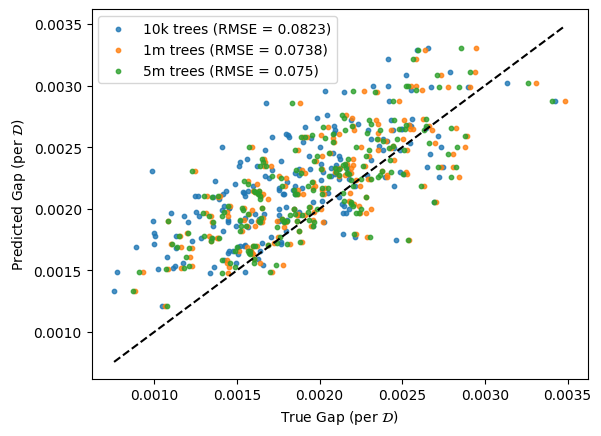

In [70]:
fig, ax = plt.subplots()

lower = np.inf
upper = -np.inf

for limit_def, num_trees in zip([limit_forest_predictions_100k, limit_forest_predictions_1m, limit_forest_predictions_5m], ["10k", "1m", "5m"]):
    comparison = np.array([
        [
            (np.mean(((get_sample_of_tree_wise_gaps(i).mean(axis=1))**2).sum(axis=2), axis=1) - get_limit_performance_on_dataset(limit_def, i)).mean(),
            get_sample_of_tree_wise_predictions(i).var(axis=(0, 1)).sum() / (t * n)
        ]
        for i in tqdm(range(200))
    ])
    lower = np.min([lower, np.min(comparison)])
    upper = np.max([upper, np.max(comparison)])
    mse = np.linalg.norm(comparison[:,0] - comparison[:,1])
    ax.scatter(comparison[:,0], comparison[:,1], label=f"{num_trees} trees (RMSE = {np.round(np.sqrt(mse), 4)})", s=10, alpha=0.8)
ax.plot([lower, upper], [lower, upper], color="black", linestyle="--")
ax.set_xlabel(r"True Gap (per $\mathcal{D}$)")
ax.set_ylabel(r"Predicted Gap (per $\mathcal{D}$)")
ax.legend()
plt.show()

## 3. Check Correctness of $\mathbb{V}_\mathcal{D}[\mathbb{E}[Z_{nt} - Z_{n\infty}|\mathcal{D}]]$

In [ ]:
vals_of_z_nt.shape

### Approximate true value of $\mathbb{V}_\mathcal{D}[\mathbb{E}[Z_{nt} - Z_{n\infty}|\mathcal{D}]]$

In [ ]:
samples_of_E_diff_true = []
for i in tqdm(range(400)):
    #print(get_sample_of_tree_wise_gaps(i).shape)
    samples_of_E_diff_true.append(float((
        (get_sample_of_tree_wise_gaps(i).mean(axis=1)**2).sum(axis=2).mean(axis=1) -
        get_limit_performance_on_dataset(i)).mean()
    ))
    #samples_of_E_diff_orig.append(float(get_sample_of_tree_wise_predictions(i).var(axis=(0, 1)).sum() / (t * n)))
    #tmp.append(np.std(samples_of_E_diff))
true_std = float(np.std(samples_of_E_diff_true))

### Estimation

In [25]:
inner_variances = tree_wise_predictions.var(axis=(0, 1))
#predictive_expression = np.sqrt().sum(axis=1).var() / (t**2 * n))
#predictive_expression

In [26]:
prediction_by_eq_1 = np.std([get_sample_of_tree_wise_predictions(i).var(axis=(0, 1)).sum() / (t * n) for i in range(400)])

In [27]:
prediction_by_eq_3 = np.sqrt(inner_variances.sum(axis=1).var() / (t**2 * n))
prediction_by_eq_3

np.float64(0.0004170330402178704)

In [28]:
inner_variances.sum

<function ndarray.sum>

In [29]:
np.abs(true_approximated_std - predictive_expression)

NameError: name 'true_approximated_std' is not defined

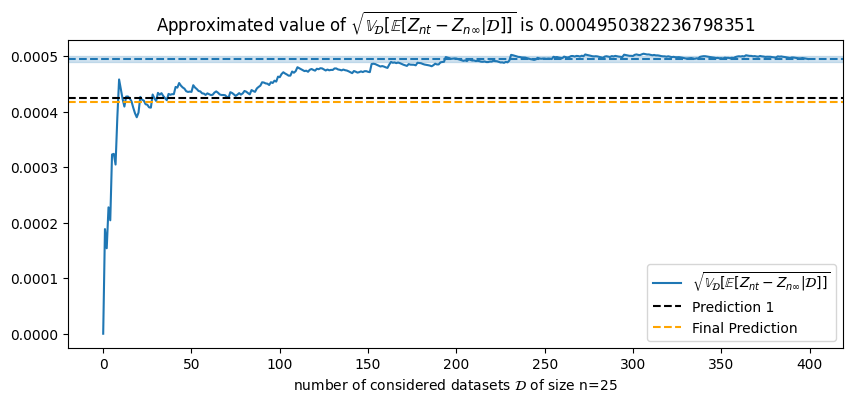

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot([np.std(samples_of_E_diff_true[:i+1]) for i in range(len(samples_of_E_diff_true))], label=r"$\sqrt{\mathbb{V}_\mathcal{D}[\mathbb{E}[Z_{nt} - Z_{n\infty}|\mathcal{D}]]}$")
ax.set_title(r"Approximated value of $\sqrt{\mathbb{V}_\mathcal{D}[\mathbb{E}[Z_{nt} - Z_{n\infty}|\mathcal{D}]]}$ is " f"{true_std}")
ax.axhline(true_std, color="C0", linestyle="--")
ax.axhspan(true_std - 0.000005, true_std + 0.000005, color="C0", alpha=0.2)

ax.axhline(prediction_by_eq_1, color="black", linestyle="--", label="Prediction 1")
ax.axhline(prediction_by_eq_3, color="orange", linestyle="--", label="Final Prediction")

         
ax.legend()
ax.set_xlabel(r"number of considered datasets $\mathcal{D}$ of size n=" f"{n}")
plt.show()

In [27]:
true_approximated_std = np.std(samples_of_E_diff)
true_approximated_std

np.float64(0.00042387277408919384)

### Predictive Estimate of $\mathbb{V}_\mathcal{D}[\mathbb{E}[Z_{nt} - Z_{n\infty}|\mathcal{D}]]$

In [30]:
assert np.abs(true_approximated_std - predictive_expression) <= 10**-5, f"Expected {true_approximated_var} but saw {predictive_expression}"

# Main Result: $\mathbb{V}[Z_{nt} - Z_{n\infty}]$

## Ground Truth

In [5]:
domain_t = [t]
domain_seeds = list(range(2500))

path = pathlib.Path("limitgaps.csv")
df_final_gaps = None if not path.exists() else pd.read_csv(path)
display(df_final_gaps)
for seed in tqdm(domain_seeds):
    if df_final_gaps is None or seed not in df_final_gaps["seed"]:
        row = [seed]
        X_val = X_test[seed * n: (seed + 1) * n]
        Y_val = Y_test[seed * n: (seed + 1) * n]
        for i, t in enumerate(domain_t):
            clf = ExtraTreesClassifier(n_estimators=t, random_state=seed, warm_start=True, **kwargs)
            clf.fit(X_train, y_train)
            y_pred_t = clf.predict_proba(X_val)
            z_t = np.mean(((y_pred_t - Y_val)**2).sum(axis=1))
            clf.n_estimators += 10**4
            clf.fit(X_train, y_train)
            y_pred_inf = clf.predict_proba(X_val)
            z_inf = np.mean(((y_pred_inf - Y_val)**2).sum(axis=1))
            gap = z_t - z_inf
            row.append(gap)
        new_df = pd.DataFrame([row], columns=["seed"] + [f"gap_{u}" for u in domain_t])
        df_final_gaps = new_df if df_final_gaps is None else pd.concat([df_final_gaps, new_df])
        df_final_gaps.to_csv(path, index=False)

,seed,gap_10
0,0,0.011983
1,1,-0.003213
2,2,0.037373
3,3,-0.014264
4,4,-0.009769
...,...,...
2682,2682,0.005480
2683,2683,0.010607
2684,2684,0.006000
2685,2685,-0.000135


  0%|          | 0/2500 [00:00<?, ?it/s]

In [6]:
from scipy.stats import bootstrap

In [7]:
print(np.var(df_final_gaps["gap_10"]))

0.0003609300879999844


In [8]:
bootstrap(df_final_gaps["gap_10"].values.reshape(1 ,-1), np.var).confidence_interval

ConfidenceInterval(low=np.float64(0.0003406143984868151), high=np.float64(0.0003848177334804742))

## Estimate

In [9]:
%%time
t_data = 10**4
n_data = 10**4
clf = ExtraTreesClassifier(n_estimators=t_data, **kwargs)

CPU times: user 16 μs, sys: 19 μs, total: 35 μs
Wall time: 40.1 μs


In [10]:
%%time
Y_hat = np.array([l.predict_proba(X_test[:n_data]) for l in clf.fit(X_train, y_train)])
Y_hat.shape

CPU times: user 10.8 s, sys: 3.96 s, total: 14.8 s
Wall time: 14.8 s


(10000, 10000, 2)

In [18]:
terms_cov_1 = []
terms_cov_2 = []
terms_cov_3 = []
for y_hat, y_true in zip(tqdm(Y_hat.transpose(1, 0, 2)), Y_test):
    y_hat = y_hat.reshape(-1, 1, 2)

    gaps = y_hat - y_true

    # covariances 1 (all shared, i.e., a variance)
    xis = []
    for i in range(t):
        xis.append((gaps[i] ** 2).sum())
    terms_cov_1.append(np.var(xis))

    # covariances 2 (only actual covariances)
    xis = []
    for i1, i2, i3 in it.combinations(range(t), 3):
        xis.append([(gaps[i1] * gaps[i2]).sum(), (gaps[i1] * gaps[i3]).sum()])
    xis = np.array(xis)
    terms_cov_2.append(np.cov(xis[:,0], xis[:,1])[0, 1])

    # covariances 3 (2 shared, i.e., a variance)
    xis = []
    for i1, i2 in it.combinations(range(t), 2):
        xis.append((gaps[i1] * gaps[i2]).sum())
    terms_cov_3.append(np.var(xis))

v = (Y_hat.var(axis=0).sum(axis=1)).var()
c1 = np.mean(terms_cov_1)
c2 = np.mean(terms_cov_2)
c3 = np.mean(terms_cov_3)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
def estimate_variance_of_gap(t, n, v, c1, c2, c3):
    return 1 / (t**3) * (t / n * v + c1 + 2 * (t - 1) * (2 * (t-2) * c2 + c3))

In [20]:
estimate_variance_of_gap(t=t, n=n, v=v, c1=c1, c2=c2, c3=c3)

np.float64(0.0027422017781290747)

In [13]:
print(np.mean(terms_cov_1), np.std(terms_cov_1))
print(np.mean(terms_cov_2), np.std(terms_cov_2))
print(np.mean(terms_cov_3), np.std(terms_cov_3))

0.025602517675206833 0.03141217801349504
0.008515465553221397 0.004815645307667405
0.014665110859890081 0.01487484220160536


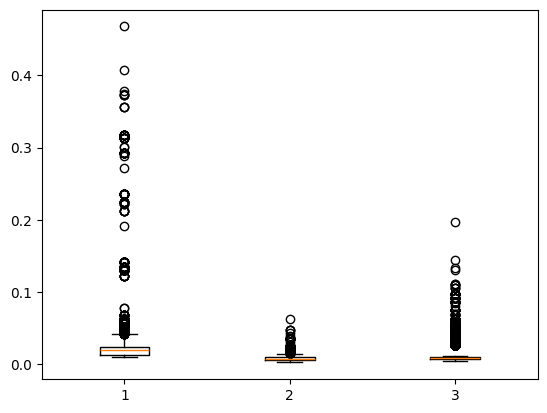

In [14]:
fig, ax = plt.subplots()
ax.boxplot([terms_cov_1, terms_cov_2, terms_cov_3])
plt.show()

In [27]:
vals = []
for i, df_i in lb.equals().combine(lb.equals(), lambda_filter=lambda r: (r["i"] == r["ip"]) & (r["s1"] == r["s3"])).lambdas.groupby("i"):
    vals.append(df_i[["lambda1", "lambda2"]].cov().values[0, 1])
c1 = np.mean(vals)
print(c1)
print(lb.equals().combine(lb.equals(), lambda_filter=lambda r: (r["i"] == r["ip"]) & (r["s1"] == r["s3"])).cov())

0.020028253762591937
0.022417000826807032


In [28]:
vals = []
sublb = lb.unequals().combine(lb.unequals(), on="i", require_right_is_not_smaller=False, lambda_filter=lambda r: (r["s1"] == r["s3"]) & (r["s2"] != r["s4"]))
for i, df_i in sublb.lambdas.groupby("i"):
    vals.append(df_i[["lambda1", "lambda2"]].cov().values[0, 1])
c2 = np.mean(vals)
print(c2)
print(sublb.cov())

0.003863342446318873
0.007832256316591133


In [29]:
vals = []
sublb = lb.unequals().combine(lb.unequals(), on="i", require_right_is_not_smaller=False, lambda_filter=lambda r: (r["s1"] == r["s3"]) & (r["s2"] == r["s4"]))
for i, df_i in sublb.lambdas.groupby("i"):
    vals.append(df_i[["lambda1", "lambda2"]].cov().values[0, 1])
c3 = np.mean(vals)
print(c3)
print(sublb.cov())

0.013707885443680323
0.01818535410395965


In [107]:
gaps.var()

np.float64(0.22023340631808083)

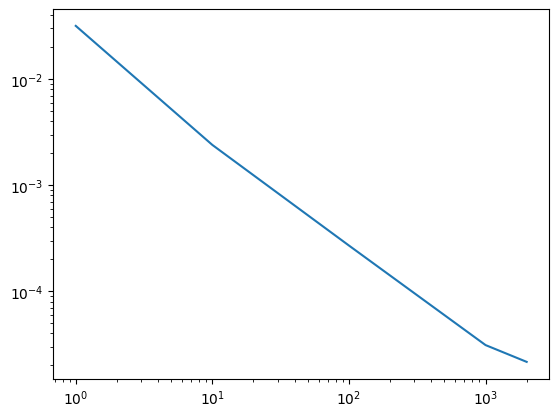

In [25]:
fig, ax = plt.subplots()
ax.plot(domain_t, gaps.var(axis=1))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

In [3]:
%%time
class Predictor:
    
    def __init__(self, X_train, X_test, y_train, y_test, clf=None, n_estimators=10**3):
        if clf is None:
            clf = ExtraTreesClassifier(n_estimators=n_estimators, random_state=0, max_depth=1).fit(X_train, y_train)
        self.clf = clf
        self.y_test_oh = get_one_hot_encoding(y_test)
        self.n = None
        self.t = None
        
    def reset(self, n, t):
        
        self.n = n
        self.t = t
        num_ensembles = min([len(self.clf) // t, len(self.y_test_oh) // n])
        
        gaps = []
        for i_ensemble in tqdm(range(num_ensembles)):
            y_pred = np.array([
                l.predict_proba(X_test[i_ensemble*n: (i_ensemble + 1) * n])
                for l in self.clf[i_ensemble * t: (i_ensemble + 1) * t]
            ])
            gaps.append(y_pred - self.y_test_oh[i_ensemble*n: (i_ensemble + 1) * n])
        self.gaps = np.array(gaps)
        self.scores = (self.gaps.mean(axis=1)**2).sum(axis=2).mean(axis=1)
        
    def estimate_E_by_first_line(self):
        ensemble_gaps_per_instance_and_target = self.gaps.mean(axis=1)
        return (ensemble_gaps_per_instance_and_target**2).sum(axis=2).mean(axis=1).mean()
    
    def estimate_E_by_third_line(self):
        ensemble_gaps_per_instance_and_target = self.gaps.mean(axis=1)
        inner_term_per_instance_and_target = ensemble_gaps_per_instance_and_target.mean(axis=0)**2 + ensemble_gaps_per_instance_and_target.var(axis=0)
        return inner_term_per_instance_and_target.sum(axis=1).mean()
    
    def estimate_E_by_seventh_line(self):
        t = self.t
        n = self.n
        k = self.gaps.shape[-1]
        
        # expected values
        term1 = (self.gaps.mean(axis=(0,1))**2).sum(axis=1).mean()
        
        # variances
        term2 = self.gaps.var(axis=0).sum(axis=(0,2)).mean() / t**2
        
        # covariances
        cov_sum = 0
        for i in range(n):
            for j in range(k):
                for s in range(t):
                    for sp in range(s):
                        cov_sum += np.cov(self.gaps[:,[s,sp], i, j].T, ddof=0)[0, 1]
        cov_sum /= (n * t**2)
        term3 = 2 * cov_sum
        
        # sum up
        return term1 + term2 + term3
    
    def estimate_E_by_iid_assumption(self):
        
        n, t = self.n, self.t
        k = self.gaps.shape[-1]
        
        # mean
        term1 = (self.gaps.mean(axis=(0,1,2))**2).sum()  # here we already sum up over the instances, ensemble members, and outer seeds
        
        # variance
        term2 = self.gaps.var(axis=(0, 1, 2)).sum() / t
        
        # co-variances
        covs = []
        for j in range(k):
            covs_for_j = []
            for s in range(t):
                c1 = self.gaps[:,s,:,j].flatten()
                for sp in range(s):
                    c2 = self.gaps[:,sp,:,j].flatten()
                    covs_for_j.append(np.cov(c1, c2, ddof=0)[0, 1])
            covs.append(np.mean(covs_for_j))
        term3 = (1 - 1/t) * sum(covs)
        return term1 + term2 + term3
    
    def test_prediction_of_E(self, n, t):
        funs = [self.estimate_E_by_first_line, self.predict_E_by_third_line, self.predict_E_by_fourth_line, self.predict_E_by_fifth_line, self.predict_E_by_sixth_line, self.predict_E_by_seventh_line]
        expected = df_results[(df_results["n"] == n) & (df_results["t"] == t)]["error"].mean()
        if np.isnan(expected):
            raise ValueError("No expected value found.")
        print(f"Expecting: {expected}")
        for i, fun in enumerate(tqdm(funs)):
            actual = fun(t=t, n=n) if i == 0 else fun(t=t)
            assert np.abs(expected - actual) <= 0.001, f"Expected {expected} but saw {actual}"
        
        for fun in tqdm(funs[-2:]):
            actual = fun(t, prob=0.1)
            assert np.abs(expected - actual) <= 0.01, f"Expected {expected} but saw {actual}"
            
    def get_covariances_for_gap_products(self):
        rows = []
        i_domain = range(self.n)
        s_domain = range(self.t)
        pbar = tqdm(total=self.n**2 * self.t**4)
        for i, ip, s1, s2, s1p, s2p in it.product(i_domain, i_domain, s_domain, s_domain, s_domain, s_domain):
            col1 = (self.gaps[:,s1,i] * self.gaps[:,s2,i]).sum(axis=1)
            col2 = (self.gaps[:,s1p,ip] * self.gaps[:,s2p,ip]).sum(axis=1)
            rows.append([i,ip,s1,s2,s1p,s2p,np.cov(col1, col2, ddof=0)[0,1]])
            pbar.update(1)
        pbar.close()
        return pd.DataFrame(rows, columns=["i", "ip", "s1", "s2", "s1p", "s2p", "cov"])
    
    def estimate_V_by_first_line(self, n, t):
        sample = self.get_error_sample(n, t, allow_crossings=True)
        return sample.var()
    
    def estimate_V_by_full_sum_of_covariances(self, n, t):
        covariances = self.get_covariances_for_gap_products(n=n, t=t)
        return covariances["cov"].sum() / (n**2 * t**4)
    
    def estimate_V_by_theorem(self, n, t):
        i_domain = range(n)
        for i, ip in it.product(i_domain, i_domain):
            print(i, ip)

predictor = Predictor(X_train, X_test, y_train, y_test, n_estimators=2*10**6)

CPU times: user 24min 13s, sys: 5 s, total: 24min 18s
Wall time: 24min 21s


In [5]:
predictor.reset(n=100, t=2000)
EZ_inf = predictor.estimate_E_by_first_line()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
predictor.gaps.shape

(1000, 2000, 100, 2)

In [ ]:
predictor.reset(n=1, t=100)
EZ_t = predictor.estimate_E_by_first_line()

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
predictor.gaps.shape

In [ ]:
diff = EZ_t - EZ_inf
diff

In [ ]:
def estimate_expected_gap_to_final_performance(self):
    
    n, t = self.n, self.t
    k = self.gaps.shape[-1]
    
    # variance
    term1 = self.gaps.var(axis=(0, 1, 2)).sum()
    
    # co-variances
    covs = []
    for j in range(k):
        covs_for_j = []
        for s in range(t):
            c1 = self.gaps[:,s,:,j].flatten()
            for sp in range(s):
                c2 = self.gaps[:,sp,:,j].flatten()
                covs_for_j.append(np.cov(c1, c2, ddof=0)[0, 1])
        covs.append(np.mean(covs_for_j))
    covs = np.array(covs)
    term2 = sum(covs)
    return (term1 - term2) / t

diff_predicted = estimate_expected_gap_to_final_performance(predictor)

In [ ]:
diff_predicted

In [ ]:
abs(diff_predicted - diff)